# Ranking with Antique

### ANTIQUE: A Non-Factoid Question Answering Benchmark
### ANTIQUE is a non-factoid question answering benchmark based on the questions and answers of Yahoo! Webscope L6.

Simple explanation of the dataset - Each Query will have a few Answers (Documents). These Documents are ranked on a relevance score of 1-4, with 4 being very relevant and 1 being not relevant. We want to use list-wise ranking methods to rank instead of treating this like a classification problem.

In [1]:
!pip install transformers
!pip install tensorflow
!pip install bert-tensorflow
!pip install tensorflow_ranking

In [2]:
!nvidia-smi

Fri Jun 19 05:32:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
import bert.tokenization as tokenization
import tensorflow as tf
import tensorflow_ranking as tfr
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import LambdaCallback, CSVLogger
from multiprocessing import Pool

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
DOC_PATH = './drive/My Drive/Antique_Dataset/antique-collection.txt'
TRAIN_ID_PATH = './drive/My Drive/Antique_Dataset/antique-train.qrel'
TRAIN_DATA_PATH = './drive/My Drive/Antique_Dataset/antique-train-queries.txt'
TEST_ID_PATH = './drive/My Drive/Antique_Dataset/antique-test.qrel'
TEST_DATA_PATH = './drive/My Drive/Antique_Dataset/antique-test-queries.txt'
VOCAB_PATH ='./drive/My Drive/Antique_Dataset/vocab.txt'

In [6]:
doc_df = pd.read_csv(DOC_PATH, sep='\t', names=['doc_id', 'doc'])
train_id_df = pd.read_csv(TRAIN_ID_PATH, sep=' ', names=['query_id', 'source', 'doc_id', 'relevance'])
train_data_df = pd.read_csv(TRAIN_DATA_PATH, sep='\t', names=['query_id', 'query'])
test_id_df = pd.read_csv(TEST_ID_PATH, sep=' ', names=['query_id', 'source', 'doc_id', 'relevance'])
test_data_df = pd.read_csv(TEST_DATA_PATH, sep='\t', names=['query_id', 'query'])

In [7]:
# The Train_ID is not standard formatting, hence created a new function to read the data. 

def read_erratic_data(path):
    query_ids, sources, doc_ids, relevances = [],[],[],[]
    with open(path, 'r') as f:
        for i,line in enumerate(f):
            if '\t' in line:
                query_id, source, doc_id, relevance = line.rstrip().split('\t')
            else:
                query_id, source, doc_id, relevance = line.rstrip().split()
            
            query_ids.append(query_id)
            sources.append(source)
            doc_ids.append(doc_id)
            relevances.append(relevance)
    
    df = pd.DataFrame({
        'query_id':query_ids,
        'source':sources,
        'doc_id':doc_ids,
        'relevance':relevances
    })
    
    #df = dd.from_pandas(df, npartitions=1)
    return df

In [8]:
train_id_df = read_erratic_data(TRAIN_ID_PATH)

In [9]:
# Checking if there's any null values
train_id_df.isnull().values.any()

False

In [10]:
# Show the doc_df 
doc_df

,doc_id,doc
0,2020338_0,A small group of politicians believed strongly...
1,2020338_1,Because there is a lot of oil in Iraq.
2,2020338_2,It is tempting to say that the US invaded Iraq...
3,2020338_3,I think Yuval is pretty spot on. It's a provin...
4,2874684_0,Call an area apiarist. They should be able to...
...,...,...
403453,1424320_5,You could try to get the owners of the propert...
403454,1424320_6,"Yes, but it depends on your Credit and Income ..."
403455,1424320_7,I can provide you non-owner financing all the ...
403456,1424320_8,"As others pointed out, there are investor lend..."


In [11]:
# JUST TO SHOW HOW THE METHODS WORK - in function preprocess_df
# Merging documents to the respective doc_ids
train_data_pre = pd.merge(train_id_df, doc_df, on='doc_id', how='left')
# Casting the query_id column to int64 type for merging
train_data_pre = train_data_pre.astype({'query_id': 'int64'})

In [12]:
# JUST TO SHOW HOW THE METHODS WORK - in function preprocess_df
# Merging the query_ids to the queries
train_data_final = pd.merge(train_data_pre, train_data_df, on='query_id', how='left')
train_data_final

,query_id,source,doc_id,relevance,doc,query
0,2531329,U0,2531329_0,4,I do it all the time. It is kind of a ritual ...,Why do some men spit into the urinal before ur...
1,2531329,Q0,2531329_5,4,To clear out the mucus deep down in the throat...,Why do some men spit into the urinal before ur...
2,2531329,Q0,2531329_4,3,"maybe they want a target to hit. Well, I gues...",Why do some men spit into the urinal before ur...
3,2531329,Q0,2531329_7,3,Where else would we spit?... Apart from sports...,Why do some men spit into the urinal before ur...
4,2531329,Q0,2531329_6,3,Because they have a cough or phlegm and hacked...,Why do some men spit into the urinal before ur...
...,...,...,...,...,...,...
27417,884731,U0,884731_0,4,Padre is a word used in both Spanish and Portu...,What does the word Padre mean in english?
27418,884731,Q0,884731_4,4,Father,What does the word Padre mean in english?
27419,884731,Q0,884731_2,4,"the word padre in english means ""father""",What does the word Padre mean in english?
27420,884731,Q0,884731_3,4,Father.,What does the word Padre mean in english?


In [13]:
# Sampling a doc that is unrelated to the query

def sample_random_example(query_id, doc_df):
    while True:
        row = doc_df.sample(n=1)
        if str(query_id) in row['doc_id'].iloc[0]:
            continue
        else:
            return row['doc'].iloc[0], row['doc_id'].iloc[0]

In [14]:
# doc, doc_id = sample_random_example(query_id, doc_df)
# print(doc)
# print(doc_id)

In [15]:
# Generating number of additional examples to add to
# make each query-doc pair have multiples of 10

def additional_count(current_total, current_number_of_pos):
    if ((current_number_of_pos*2 + current_total)//10) * 10 < current_total:
        number = current_total*2 // 10 * 10 - current_total
    else:
        number = ((current_number_of_pos*2 + current_total)//10) * 10 - current_total
    if number + current_total < 10:
        return 10 - current_total
    if (number > current_total):
        number = number - (current_number_of_pos//10 * 10)
    return number

In [16]:
# Full function used in preprocess_df
# To add additional unrelevant examples to training dataset because of lack of representation
# in the dataset

def add_random_examples(data, doc_df):
    df = data.copy()
    unique_queries = df['query_id'].unique()
    result = pd.DataFrame()
    for query_id in unique_queries:
        test = df.loc[df['query_id'] == query_id]
        query = test['query'].iloc[0]
        total = test.count()[0]
        count = test.loc[test['relevance'] == "4"].count()[0]
        number = additional_count(total, count)
        for i in range(number):
            doc, doc_id = sample_random_example(query_id, doc_df)
            line = pd.DataFrame({'query_id': query_id,
                                'source': 'Generated',
                                 'doc_id': doc_id,
                                'relevance': '1',
                                 'doc': str(doc),
                                'query': str(query),
                                }, index=[i])
            test = test.append(line, ignore_index=False)
        test = test.sample(frac=1).reset_index(drop=True)
        result = result.append(test, ignore_index=False)
    result.reset_index(drop=True, inplace=True)
    return result

In [17]:
# # Testing the function
# train_data_final = add_random_examples(train_data_final, doc_df)

In [18]:
# train_data_final

In [19]:
# train_data_final['relevance'].value_counts()

In [20]:
# train_data_final.iloc(0)[5]

In [21]:
# Merging the query and doc pairs into one tokenized represenation for BERT
# input_ids: [CLS] [query] [SEP] [doc] [SEP]
# token_type_ids: 0 for tokens representing the query tokens, 1 for tokens representing doc tokens
# attention_mask: 1 for non-padding tokens, 0 for padding tokens

def tokenizeforBert(data):
    print('Tokenizing.....')
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    
    df = data.filter(['query','doc']).applymap(lambda x: tokenizer.tokenize(x))
    df['input_ids'] = df.apply(lambda row: tokenizer.encode_plus(text=row['query'],
                                                                text_pair=row['doc'],
                                                                max_length=512,
                                                                truncation_strategy='only_second',
                                                                pad_to_max_length=True,
                                                                padding_side='right',
                                                                is_pretokenized=False,
                                                                )['input_ids'], axis=1)
    df['token_type_ids'] = df.apply(lambda row: tokenizer.encode_plus(text=row['query'],
                                                                text_pair=row['doc'],
                                                                max_length=512,
                                                                truncation_strategy='only_second',
                                                                pad_to_max_length=True,
                                                                padding_side='right',
                                                                is_pretokenized=False,
                                                                return_token_type_ids=True,
                                                                )['token_type_ids'], axis=1)
    df['attention_mask'] = df.apply(lambda row: tokenizer.encode_plus(text=row['query'],
                                                                text_pair=row['doc'],
                                                                max_length=512,
                                                                truncation_strategy='only_second',
                                                                pad_to_max_length=True,
                                                                padding_side='right',
                                                                is_pretokenized=False,
                                                                return_attention_mask=True,
                                                                )['attention_mask'], axis=1)
    
    total_df = pd.concat([data, df.filter(['input_ids','token_type_ids','attention_mask'])], axis=1)
    
    return total_df

In [22]:
# Convert inputs into tokens that will be pre-processed

def preprocess_df(doc_df, query_df, link_df, mode='test'):
    #casting the query_id column to int64 type for merging
    queries = query_df.astype({'query_id': 'int64'}) 
    data_pre = link_df.astype({'query_id': 'int64'})
    #merging documents to the respective doc_ids
    data_pre = pd.merge(data_pre, queries, on='query_id', how='left')
    #merging queries to the respective query_ids
    data = pd.merge(data_pre, doc_df, on='doc_id', how='left')
    data = data.dropna()
    data = data.reset_index(drop=True)
    if mode == 'train':
        print('Adding Random Examples')
        data = add_random_examples(data, doc_df)
        print('Finished adding examples')
    
    
    data = tokenizeforBert(data)
    
    return data

In [23]:
train_df = preprocess_df(doc_df, train_data_df, train_id_df, mode='train')

Adding Random Examples
Finished adding examples
Tokenizing.....


In [24]:
train_df

,query_id,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask
0,2531329,Q0,2531329_1,2,Why do some men spit into the urinal before ur...,Sorry. Didn't know you were watching.,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,2531329,Q0,2531329_3,3,Why do some men spit into the urinal before ur...,men (cough cough - boys) are just wierd...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,2531329,Generated,195886_0,1,Why do some men spit into the urinal before ur...,it is better to take points when you listen to...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,2531329,Q0,2531329_4,3,Why do some men spit into the urinal before ur...,"maybe they want a target to hit. Well, I gues...","[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,2531329,Q0,2531329_5,4,Why do some men spit into the urinal before ur...,To clear out the mucus deep down in the throat...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...
45335,884731,Generated,1735337_1,1,What does the word Padre mean in english?,Viral are coused by viruses . Bacterial are ca...,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
45336,884731,U0,884731_0,4,What does the word Padre mean in english?,Padre is a word used in both Spanish and Portu...,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
45337,884731,Q0,884731_2,4,What does the word Padre mean in english?,"the word padre in english means ""father""","[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
45338,884731,Q0,884731_4,4,What does the word Padre mean in english?,Father,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ..."


In [33]:
# Passing tokenized inputs into pre-trained BERT model to obtain 
# dense represenations of the query-doc pair

# Batch_size used is 64, can adjust based on available RAM - Used batch_size 64 for GPU

def convert_BERT_embeddings(input_ids, token_type_ids, attention_mask, model, batch_size=64):
#     print(input_ids)
    start_time = time.time()
    length = len(input_ids)
    print(length)
    print(input_ids)
    input_ids_tensor = tf.constant(input_ids, shape=(length, 512))
    token_type_ids_tensor = tf.constant(token_type_ids, shape=(length, 512))
    attention_mask_tensor = tf.constant(attention_mask, shape=(length, 512))
    total_time = 0
    start_time = time.time()
    for i in range(0, length, batch_size):
        batch_time = time.time()
        if i % batch_size == 0:
            time_passed = int(time.time() - start_time)
            hours_remaining = (length - i) * time_passed / (max(1.0, i) * 3600)
            print(f"Hours remaining: {hours_remaining}")
            
            
        if (i+batch_size) >= length:
            features = {
                "input_ids": input_ids_tensor[i:length],
                "attention_mask": attention_mask_tensor[i:length],
                "token_type_ids": token_type_ids_tensor[i:length],
            }
        
        features = {
            "input_ids": input_ids_tensor[i:i+batch_size],
            "attention_mask": attention_mask_tensor[i:i+batch_size],
            "token_type_ids": token_type_ids_tensor[i:i+batch_size],
        }
        output = model(features)
        print(f"{i + batch_size} Examples done.")
        last_hidden_state = output[0]
        # taking the representation of the first token (CLS)
        CLS = tf.slice(last_hidden_state, [0,0,0], [-1,1,-1]) 
        CLS = tf.squeeze(CLS)
        
        if i == 0:
            overall = CLS
            print(CLS)
        else:
            overall = tf.concat([overall, CLS], 0)

        
        batch_time = int(time.time() - batch_time)
        total_time += batch_time
        print(f"Time taken: {batch_time}")
        
    print(overall)
    print(f"Total time taken: {total_time/3600} hours")
    overall = overall.numpy()
    return overall

In [34]:
def convert_dflist_to_array(series):
  print('Starting....')
  start = time.time()
  array = np.array(series[0])
  for i in range(1,len(series)):
    array = np.vstack((array, np.array(series[i])))
  print('Finished....')
  print(f'Took {time.time() - start} seconds')
  return array

In [30]:
len(train_df['attention_mask'][0])

512

In [31]:
# Takes pretty long as well, around 40mins
input_ids_array = convert_dflist_to_array(train_df['input_ids'])
token_ids_array = convert_dflist_to_array(train_df['token_type_ids'])
attention_array = convert_dflist_to_array(train_df['attention_mask'])

Starting....
Finished....
Took 817.6357445716858 seconds
Starting....
Finished....
Took 830.1354570388794 seconds
Starting....
Finished....
Took 941.0075414180756 seconds


In [37]:
# Optimized by vectorization, should take less than an hour.

model = TFBertModel.from_pretrained('bert-base-uncased')
array = convert_BERT_embeddings(input_ids_array, token_ids_array, attention_array, model, batch_size=64)

45340
[[ 101 2339 2079 ...    0    0    0]
 [ 101 2339 2079 ...    0    0    0]
 [ 101 2339 2079 ...    0    0    0]
 ...
 [ 101 2054 2515 ...    0    0    0]
 [ 101 2054 2515 ...    0    0    0]
 [ 101 2054 2515 ...    0    0    0]]
Hours remaining: 0.0
64 Examples done.
tf.Tensor(
[[ 0.14038418 -0.07637009  0.17652397 ... -0.283847    0.20487404
   0.51430064]
 [-0.07574555  0.38415992 -0.47838423 ... -0.749177    0.4957385
   0.47700477]
 [ 0.23570272 -0.14938566  0.16130978 ...  0.32744983  0.2920798
   0.6294467 ]
 ...
 [ 0.08666984  0.54366446 -0.26771805 ... -0.22095335  0.3800056
   0.6179672 ]
 [-0.34183842  0.2337947  -0.41144612 ... -0.72418374  0.31837457
   0.6540762 ]
 [ 0.26563123  0.241605   -0.38411635 ... -0.25714254  0.28801677
   0.7045928 ]], shape=(64, 768), dtype=float32)
Time taken: 4
Hours remaining: 0.7860416666666666
128 Examples done.
Time taken: 0
Hours remaining: 0.4905815972222222
192 Examples done.
Time taken: 4
Hours remaining: 0.5878645833333334
256 Ex

In [38]:
# Saving the bert_embeddings to a tsv file (Already done that)

def save_to_tsv(df, bert_embedding, file='train'):
    df['bert_embeddings'] = 1
    df = df.reset_index(drop=True)
    df = df.astype('object')
    for i in range(len(df)):
        df['bert_embeddings'][i] = list(bert_embedding[i])
    df.to_csv('./drive/My Drive/antique_'+file+'_bert.tsv', sep='\t', index=False)
    return df

In [39]:
save_to_tsv(train_df, array)

,query_id,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
0,2531329,Q0,2531329_1,2,Why do some men spit into the urinal before ur...,Sorry. Didn't know you were watching.,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.14038418, -0.07637009, 0.17652397, -0.21174..."
1,2531329,Q0,2531329_3,3,Why do some men spit into the urinal before ur...,men (cough cough - boys) are just wierd...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.075745545, 0.38415992, -0.47838423, -0.429..."
2,2531329,Generated,195886_0,1,Why do some men spit into the urinal before ur...,it is better to take points when you listen to...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.23570272, -0.14938566, 0.16130978, 0.077973..."
3,2531329,Q0,2531329_4,3,Why do some men spit into the urinal before ur...,"maybe they want a target to hit. Well, I gues...","[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.52939916, 0.5299391, -0.4963811, -0.319871..."
4,2531329,Q0,2531329_5,4,Why do some men spit into the urinal before ur...,To clear out the mucus deep down in the throat...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.40824068, 0.6845711, -0.53848433, -0.36029..."
...,...,...,...,...,...,...,...,...,...,...
45335,884731,Generated,1735337_1,1,What does the word Padre mean in english?,Viral are coused by viruses . Bacterial are ca...,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.13169761, -0.42254418, 0.18341595, 0.213759..."
45336,884731,U0,884731_0,4,What does the word Padre mean in english?,Padre is a word used in both Spanish and Portu...,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.5623697, 0.4166778, -0.59484327, -0.324400..."
45337,884731,Q0,884731_2,4,What does the word Padre mean in english?,"the word padre in english means ""father""","[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.64837384, 0.5308057, -0.57113624, -0.39678..."
45338,884731,Q0,884731_4,4,What does the word Padre mean in english?,Father,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[-0.28291002, 0.19619924, 0.1452271, -0.223253..."


In [40]:
test_df = preprocess_df(doc_df, test_data_df, test_id_df)

Tokenizing.....


In [41]:
test_input_ids_array = convert_dflist_to_array(test_df['input_ids'])
test_token_ids_array = convert_dflist_to_array(test_df['token_type_ids'])
test_attention_array = convert_dflist_to_array(test_df['attention_mask'])

Starting....
Finished....
Took 13.457768440246582 seconds
Starting....
Finished....
Took 12.855457544326782 seconds
Starting....
Finished....
Took 15.083302021026611 seconds


In [42]:
test_results = convert_BERT_embeddings(test_input_ids_array, test_token_ids_array, test_attention_array, model)

6589
[[ 101 2054 2079 ...    0    0    0]
 [ 101 2054 2079 ...    0    0    0]
 [ 101 2054 2079 ...    0    0    0]
 ...
 [ 101 2129 2064 ...    0    0    0]
 [ 101 2129 2064 ...    0    0    0]
 [ 101 2129 2064 ...    0    0    0]]
Hours remaining: 0.0
32 Examples done.
tf.Tensor(
[[-1.17683396e-01  3.81208867e-01 -8.14802289e-01 ... -8.22204590e-01
   3.26010078e-01  3.79400402e-01]
 [-1.85377315e-01  2.64670372e-01 -7.37730503e-01 ... -7.93308794e-01
   5.71447849e-01  4.38526720e-01]
 [-7.37383962e-04  2.45374054e-01 -5.02342641e-01 ... -7.93728828e-01
   4.80002075e-01  2.88361311e-01]
 ...
 [-8.03529844e-03  3.29554439e-01 -8.22576344e-01 ... -8.17882776e-01
   4.07812715e-01  5.12130857e-01]
 [-2.18114167e-01  1.10390559e-01 -7.15333939e-01 ... -8.53121936e-01
   5.11326909e-01  3.33784044e-01]
 [-1.33946270e-01  3.97515237e-01 -6.51897848e-01 ... -4.66872185e-01
   4.71556723e-01  5.84702790e-01]], shape=(32, 768), dtype=float32)
Time taken: 2
Hours remaining: 0.113836805555555

In [43]:
save_to_tsv(test_df, test_results, file='test')

,query_id,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
0,1964316,U0,1964316_5,4,"What do you mean by ""weed""?",Weed could mean the bad thing that grow in ur ...,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.117683396, 0.38120887, -0.8148023, -0.2977..."
1,1964316,Q0,1674088_11,1,"What do you mean by ""weed""?",sell weed,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[-0.18537731, 0.26467037, -0.7377305, -0.18130..."
2,1964316,Q0,1218838_13,2,"What do you mean by ""weed""?",My weed!!,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.00073738396, 0.24537405, -0.50234264, -0.4..."
3,1964316,Q0,1519022_15,2,"What do you mean by ""weed""?",because we dont know what the hell to make leg...,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.31584862, 0.08820932, -0.56504595, -0.2485..."
4,1964316,Q0,3059341_5,2,"What do you mean by ""weed""?",Its a weed.,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.13292149, 0.30342782, -0.52649224, -0.3847..."
...,...,...,...,...,...,...,...,...,...,...
6584,1262692,Q0,247023_6,3,How can I get rid of pimples on my back?,if there is a head on it you can take a piece ...,"[101, 2129, 2064, 1045, 2131, 9436, 1997, 1425...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.4966618, 0.25597742, -0.63771343, -0.46903..."
6585,1262692,Q0,1499030_5,3,How can I get rid of pimples on my back?,"Cut down on sugary and oily foods, make sure y...","[101, 2129, 2064, 1045, 2131, 9436, 1997, 1425...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.3382789, 0.19795184, -0.88143057, -0.03786..."
6586,1262692,Q0,2916758_0,3,How can I get rid of pimples on my back?,Sounds like you may have gotten immune to the ...,"[101, 2129, 2064, 1045, 2131, 9436, 1997, 1425...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.25428507, 0.061954655, -0.7148295, -0.3484..."
6587,1262692,Q0,1105845_15,3,How can I get rid of pimples on my back?,the best way to lose pimples is use either pro...,"[101, 2129, 2064, 1045, 2131, 9436, 1997, 1425...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.25733668, 0.3421137, -0.53493476, -0.47761..."


# TF-Ranking Model

### The TF-Ranking DNN Model is used in this project - it requires data in Example List With Context (ELWC) Format, which will be created by example_columns. In this Ranking situation, since dense representations include the query and the doc, we will leave the example_column empty.

In [135]:
list_size = 10
batch_size = 5
number_of_features = 768
valid_set_ratio = 0.15

In [136]:
# Reading the pre-processed data into a dataframe

train_df = pd.read_csv('./drive/My Drive/antique_train_bert.tsv', sep='\t')
test_df = pd.read_csv('./drive/My Drive/antique_test_bert.tsv', sep='\t')

In [137]:
valid_index = int(len(train_df) * (1 - valid_set_ratio))
vali_df = train_df[valid_index:len(train_df)]
vali_df.reset_index(drop= True, inplace=True)
train_df = train_df[0:valid_index]

In [138]:
print(len(train_df))
print(len(vali_df))
print(len(test_df))

38539
6801
6589


In [139]:
# Showing the average number of documents per query
train_df.groupby(['query_id']).count().describe()

,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
count,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000,2096.000000
mean,18.386927,18.386927,18.386927,18.386927,18.386927,18.386927,18.386927,18.386927,18.386927
std,14.134830,14.134830,14.134830,14.134830,14.134830,14.134830,14.134830,14.134830,14.134830
min,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000
25%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
max,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000


In [140]:
# Showing number of documents per query_id
train_df.groupby('query_id').count()

,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
query_id,,,,,,,,,
751,20,20,20,20,20,20,20,20,20
1763,20,20,20,20,20,20,20,20,20
2704,40,40,40,40,40,40,40,40,40
3961,30,30,30,30,30,30,30,30,30
4409,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...
4473502,10,10,10,10,10,10,10,10,10
4477752,10,10,10,10,10,10,10,10,10
4477858,20,20,20,20,20,20,20,20,20


In [141]:
# Distribution of relevance scores per data
train_df['relevance'].value_counts(normalize=True)

1    0.421936
4    0.259192
3    0.177275
2    0.141597
Name: relevance, dtype: float64

In [142]:
vali_df['relevance'].value_counts(normalize=True)

1    0.433025
4    0.255110
3    0.183061
2    0.128805
Name: relevance, dtype: float64

In [143]:
test_df['relevance'].value_counts(normalize=True)

2    0.366823
1    0.249203
4    0.202459
3    0.181515
Name: relevance, dtype: float64

In [144]:
def convert_dflist_to_array(series, start):
  array = np.array(series[start])
  for i in range(start+1,start+len(series)):
    array = np.vstack((array, np.array(series[i])))
  return array

In [145]:
# Generator to yield n examples for 1 list for list_wise comparison

def generator(dataframe, mode):
    length = len(dataframe)
    for i in itertools.count(0, list_size):
        step = i%length
        if step+list_size > length:
            if mode == 'test':
                return
            else:
                continue
        array = dataframe['bert_embeddings'][step:step+list_size].apply(lambda data: list(map(lambda x: float(x), data.strip('][').split(', '))))
        array = convert_dflist_to_array(array, step)
        bert_tensor = tf.constant(array)
        labels = tf.constant(dataframe['relevance'][step:step+list_size].astype('int32'))
        yield ({'example_list': bert_tensor}, labels)
        

In [146]:
# Converting the dataframe into a dataset for Keras training

def df_to_dataset(dataframe, batch_size=8, mode='train'):
    dataframe = dataframe.copy()
    dataframe = dataframe.filter(['query_id', 'bert_embeddings', 'relevance'])
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(dataframe, mode),
        output_types = ({
            'example_list': tf.float32,
        },
        tf.float32
        ),
        output_shapes = ({
            'example_list': tf.TensorShape([list_size, 768])
        },
        tf.TensorShape(list_size)
        )
    )
    if mode == 'train':
        return dataset.repeat().batch(batch_size, drop_remainder=True)
    elif mode == 'test':
        return dataset.batch(batch_size, drop_remainder=True)

In [147]:
train_dataset = df_to_dataset(train_df, batch_size, mode='train')

In [148]:
vali_dataset = df_to_dataset(vali_df, batch_size, mode='train')

In [149]:
test_dataset = df_to_dataset(test_df, 1, mode='test')

In [150]:
list(train_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(5, 10, 768), dtype=float32, numpy=
   array([[[ 0.14038418, -0.07637009,  0.17652397, ..., -0.283847  ,
             0.20487404,  0.51430064],
           [-0.07574555,  0.38415992, -0.47838423, ..., -0.749177  ,
             0.4957385 ,  0.47700477],
           [ 0.23570272, -0.14938566,  0.16130978, ...,  0.32744983,
             0.2920798 ,  0.6294467 ],
           ...,
           [-0.26474723,  0.3622378 , -0.37632445, ..., -0.5626925 ,
             0.31560117,  0.5076609 ],
           [-0.2236495 ,  0.45706183, -0.39957872, ..., -0.6166152 ,
             0.6112313 ,  0.39875662],
           [ 0.14848402, -0.03265639, -0.13672888, ..., -0.38954368,
             0.77079105,  0.8005348 ]],
   
          [[-0.5739275 ,  0.07634123, -0.26920247, ..., -0.7442187 ,
             0.31625324,  0.9963859 ],
           [-0.52679235,  0.24064499, -0.22345567, ..., -0.65498126,
             0.7103799 ,  0.7414924 ],
           [-0.65901154,  0.2748386 , -0.3

In [151]:
list(vali_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(5, 10, 768), dtype=float32, numpy=
   array([[[-0.30326697,  0.385008  , -0.5557953 , ..., -0.8744441 ,
             0.40856823,  0.525788  ],
           [-0.41935375,  0.41798252, -0.20649868, ..., -0.89292026,
             0.75350946,  0.28068644],
           [ 0.6620403 ,  0.14721273,  0.44512787, ...,  0.83135283,
            -0.1293756 ,  0.65905505],
           ...,
           [ 0.26212803, -0.20209822,  0.08252018, ...,  0.5740647 ,
             0.05008253,  0.81685317],
           [-0.25754195,  0.266529  , -0.18158972, ..., -0.5824502 ,
             0.6726414 ,  0.37460557],
           [-0.15456645,  0.36218303, -0.17318234, ..., -0.6679565 ,
             0.6568986 ,  0.45532167]],
   
          [[ 0.11080675,  0.4429331 ,  0.08703566, ..., -0.5045014 ,
             0.5631529 ,  0.4718675 ],
           [ 0.308203  ,  0.41947904,  0.19090241, ..., -0.2178424 ,
             0.25025713,  0.9409113 ],
           [ 0.05072198,  0.06883341, -0.0

In [152]:
list(test_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
   array([[[-1.17683396e-01,  3.81208867e-01, -8.14802289e-01, ...,
            -8.22204590e-01,  3.26010078e-01,  3.79400402e-01],
           [-1.85377315e-01,  2.64670372e-01, -7.37730503e-01, ...,
            -7.93308794e-01,  5.71447849e-01,  4.38526720e-01],
           [-7.37383962e-04,  2.45374054e-01, -5.02342641e-01, ...,
            -7.93728828e-01,  4.80002075e-01,  2.88361311e-01],
           ...,
           [-3.03227417e-02,  3.78060430e-01, -5.47235191e-01, ...,
            -5.93945980e-01,  4.25843835e-01,  5.23683846e-01],
           [-2.39873230e-01,  1.86081588e-01, -6.52836680e-01, ...,
            -8.71924996e-01,  6.28163457e-01,  2.96366781e-01],
           [-9.17422399e-02,  2.04006284e-01, -5.94009161e-01, ...,
            -7.48472452e-01,  4.27416027e-01,  4.83124435e-01]]],
         dtype=float32)>},
  <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[4., 1., 2., 2., 2., 2., 2., 2., 

In [153]:
# Defining what 1 example is: A dense representation of query-doc pair in the form of
# an array of 768 values

def example_feature_columns():
    embedding_column = tf.feature_column.numeric_column(key='example_list',
                                                       shape=(number_of_features))
    example_feature_columns = {'example_list': embedding_column}
    
    
    return example_feature_columns

In [154]:
# Using the TF-Ranking library and their DNN Network

network = tfr.keras.canned.DNNRankingNetwork(
    context_feature_columns={},
    example_feature_columns=example_feature_columns(),
    hidden_layer_dims=[1024, 512, 256],
    activation=tf.nn.relu,
    dropout=0.5
)

In [155]:
# network = tfr.keras.canned.GAMRankingNetwork(
#     context_feature_columns=None,
#     example_feature_columns=example_feature_columns(),
#     example_hidden_layer_dims=[1024, 256, 32],
#     activation=tf.nn.relu,
#     dropout=0.2,
#     use_batch_norm=True,
#     batch_norm_moment=0.999,
#     name="gam_ranking_network")

In [156]:
# Using Softmax loss for list_wise inference and NDCG for metrics

softmax_loss_obj = tfr.keras.losses.get(tfr.losses.RankingLossKey.SOFTMAX_LOSS)
default_metrics = tfr.keras.metrics.default_keras_metrics()

## DCG - Discounted Cumulative Gain
DCG is based on the premise that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically propotional to the result.
### DCG at rank position $p$ is defined as:
### $DCG_p$ = $rel_1$ + $\sum_{i=2}^{p} \frac{2^{rel_i} - 1}{log_2(i+1)}$	

where $rel_i$ is the graded relevance (label) of the result at position $i$

## NDCG - Normalized Discounted Cumulative Gain

Since search results lists vary in length depending on query, a more consistent approach is to use NDCG where NDCG is defined by sorting all relevant documents by their relative relevance to produce the maximum possible DCG through position $p$ (also known as the Ideal DCG (IDCG)), and taking the search result's DCG divided by the IDCG.

### $nDCG_p$ = $\frac{DCG_p}{IDCG_p}$

This means that NDCG@n is the fraction of the DCG of the top n computed search results divided over the DCG of the top n relevant search results.

In [157]:
ranker = tfr.keras.model.create_keras_model(
    network=network,
    loss=softmax_loss_obj,
    metrics=default_metrics,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
    size_feature_name = None
)

In [158]:
ranker.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
example_list (InputLayer)    [(None, None, 768)]       0         
_________________________________________________________________
dnn_ranking_network (DNNRank (None, None)              1454081   
Total params: 1,454,081
Trainable params: 1,448,961
Non-trainable params: 5,120
_________________________________________________________________


In [159]:
ranker.get_config()

{'input_layers': {'example_list': ['example_list', 0, 0]},
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, 768),
    'dtype': 'float32',
    'name': 'example_list',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'example_list'},
  {'class_name': 'DNNRankingNetwork',
   'config': {'activation': 'relu',
    'batch_norm_moment': 0.999,
    'context_feature_columns': {},
    'dropout': 0.5,
    'dtype': 'float32',
    'example_feature_columns': {'example_list': {'class_name': 'NumericColumn',
      'config': {'default_value': None,
       'dtype': 'float32',
       'key': 'example_list',
       'normalizer_fn': None,
       'shape': (768,)}}},
    'hidden_layer_dims': ListWrapper([1024, 512, 256]),
    'name': 'dnn_ranking_network',
    'trainable': True,
    'use_batch_norm': True},
   'inbound_nodes': [{'example_list': ['example_list', 0, 0, {'mask': None}]}],
   'name': 'dnn_ranking_network'}],
 'name': 'model',
 'o

In [160]:
checkpoint = ModelCheckpoint('./drive/My Drive/Antique_Dataset/checkpoints/best_weights.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
tsv = CSVLogger('./drive/My Drive/Antique_Dataset/outputs/training_stats.tsv', separator='\t', append=False)

In [161]:
hist = ranker.fit(
    train_dataset,
    validation_data=vali_dataset,
    verbose=1,
    steps_per_epoch = int(len(train_df) / (batch_size * list_size)),
    epochs=40,
    validation_steps = int(len(vali_df) / (batch_size * list_size)),
    callbacks = [checkpoint, tsv]
)

Epoch 1/40
769/770 [============================>.] - ETA: 0s - loss: 51.1969 - metric/ndcg_1: 0.7455 - metric/ndcg_3: 0.7845 - metric/ndcg_5: 0.8408 - metric/ndcg_10: 0.9027 - metric/arp: 4.5170 - metric/ordered_pair_accuracy: 0.8344 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 32.8027 - metric/ndcg: 0.9027
Epoch 00001: val_loss improved from inf to 50.14763, saving model to ./drive/My Drive/Antique_Dataset/checkpoints/best_weights.hdf5
770/770 [==============================] - 41s 53ms/step - loss: 51.1853 - metric/ndcg_1: 0.7455 - metric/ndcg_3: 0.7846 - metric/ndcg_5: 0.8409 - metric/ndcg_10: 0.9028 - metric/arp: 4.5167 - metric/ordered_pair_accuracy: 0.8345 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 32.7934 - metric/ndcg: 0.9028 - val_loss: 50.1476 - val_metric/ndcg_1: 0.8044 - val_metric/ndcg_3: 0.8188 - val_metric/ndcg_5: 0.8650 - val_metric/ndcg_10: 0.9199 - val_metric/arp: 4.4283 - val_metric/ordere

In [162]:
result_last = ranker.evaluate(test_dataset)

658/658 [==============================] - 14s 21ms/step - loss: 53.8394 - metric/ndcg_1: 0.6164 - metric/ndcg_3: 0.6515 - metric/ndcg_5: 0.7155 - metric/ndcg_10: 0.8401 - metric/arp: 5.1509 - metric/ordered_pair_accuracy: 0.6578 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 28.1892 - metric/ndcg: 0.8401


In [163]:
ranker.load_weights('./drive/My Drive/Antique_Dataset/checkpoints/best_weights.hdf5')

In [164]:
result = ranker.evaluate(test_dataset)

658/658 [==============================] - 13s 20ms/step - loss: 53.7387 - metric/ndcg_1: 0.6206 - metric/ndcg_3: 0.6659 - metric/ndcg_5: 0.7257 - metric/ndcg_10: 0.8445 - metric/arp: 5.1301 - metric/ordered_pair_accuracy: 0.6657 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 28.3293 - metric/ndcg: 0.8445


# Results

We got 0.7257 for nDCG_5, using the best saved model (lowest validation loss) which is decent, but a far cry from the validation metric of val_ndcg_5 of 0.8839. Part of the reason is that the training data is grouped in lists of 10, and all query-doc pairs are based on the same query, but for the test data, it is not based on the same query as data can't be made up for the test dataset. 

This is also an improvement from a separate run where additional irrelevant data was not created to balance the bias in the training dataset, where that run achieve 0.7044 nDCG_5 for the test dataset. 

In [165]:
import matplotlib.pyplot as plt
def plot_train(hist):
    h = hist.history
    i = 0
    for metric in h.keys():
        if 'val' in metric:
            return
        plt.figure(i)
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+metric])
        plt.title('model '+metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'])
        i += 1

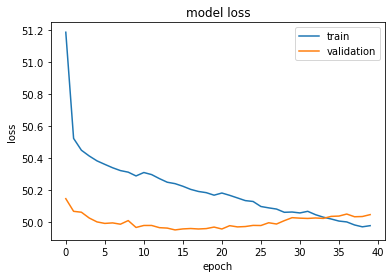

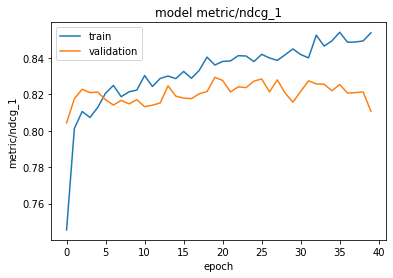

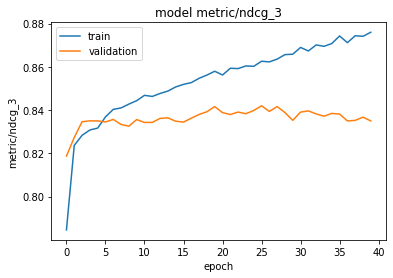

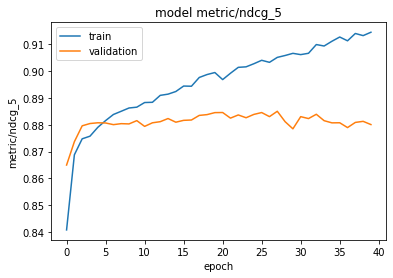

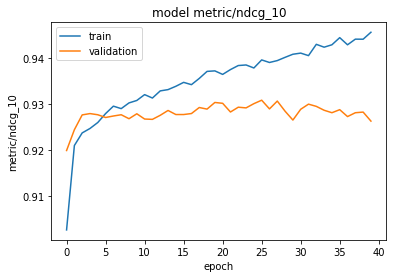

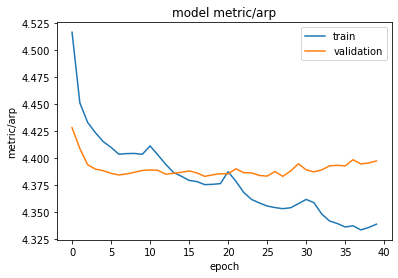

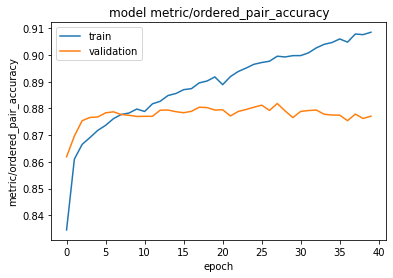

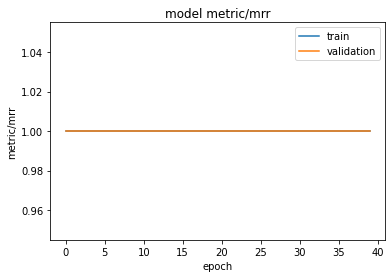

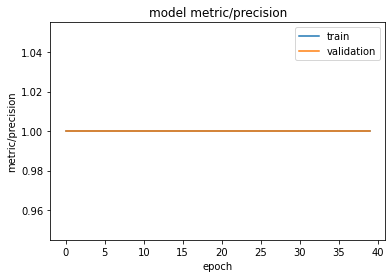

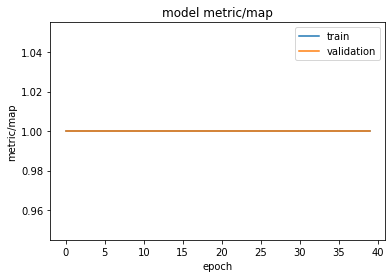

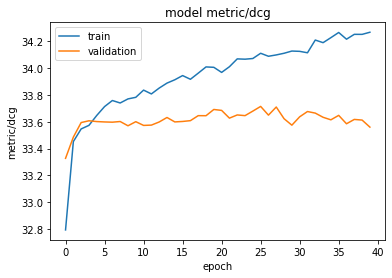

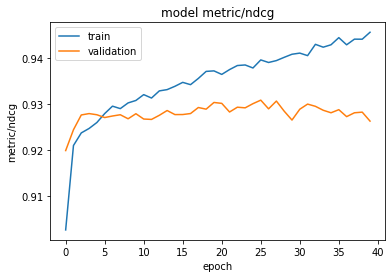

In [166]:
plot_train(hist)

In [167]:
result

[53.73866653442383,
 0.6205826997756958,
 0.6658665537834167,
 0.7257270216941833,
 0.8444922566413879,
 5.130137920379639,
 0.6657493710517883,
 1.0,
 1.0,
 1.0,
 28.329282760620117,
 0.8445172905921936]